In [22]:
import numpy as np
from sklearn.covariance import empirical_covariance

from regain import datasets
from regain.admm import latent_time_graph_lasso_; reload(latent_time_graph_lasso_)
from regain.admm import latent_graph_lasso_; reload(latent_graph_lasso_);

In [23]:
# config
n_samples = 100
n_dim_obs = 10
n_dim_lat = 2
T = 10

dataset = datasets.generate_dataset(
        mode='fixed', n_samples=n_samples, n_dim_lat=n_dim_lat,
        n_dim_obs=n_dim_obs, T=T)

# assert np.linalg.matrix_rank(ells) == n_dim_lat

## 1. Single timestamp
Check if, with only one timestamp, the method behave the same as Chandrasekaran/Ma.

In [24]:
emp_cov = empirical_covariance(dataset.data[0], assume_centered=False)

### 1.1 Do we behave as ourselves with the same functional as Ma?
The following is the latent time graphical model inference with only one covariance matrix.

In [25]:
results_time = latent_time_graph_lasso_.latent_time_graph_lasso(
    np.array([emp_cov]), alpha=0.05, tau=0.25,
    tol=1e-5, rtol=1e-5, rho=1./ emp_cov.shape[0],
    verbose=0, max_iter=500)

We compare it with the code for the latent graphical model inference (without time). <br>
Since there is only one covariance matrix, we expect to obtain the same results.

In [26]:
results_static = latent_graph_lasso_.latent_graph_lasso(
    emp_cov, alpha=0.05, tau=0.25, 
    tol=1e-5, rtol=1e-5, rho=1. / emp_cov.shape[0],
    verbose=0, max_iter=500)

In [30]:
assert np.all([np.allclose(x, y) for x, y in zip(results_static, results_time)])

In [31]:
assert np.linalg.matrix_rank(results_static[1]) == np.linalg.matrix_rank(results_time[1][0])

Now we check if the result is the same as the Chandrasekaran/Ma Matlab algorithm. To do that, we load `matlab.engine`, to run Matlab code directly from Python. It requires Matlab 2016 or higher installed.

In [43]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath(r'/home/fede/src/slipguru/regain/regain/wrapper/lvglasso/',nargout=0)

In [44]:
from sklearn.datasets.base import Bunch
result = eng.ADMM_MA_single_time(matlab.double(emp_cov.tolist()),0.05,0.25)
ma_output = Bunch(**result)

ma_output.R = np.array(ma_output.R)
ma_output.S = np.array(ma_output.S)
ma_output.L = np.array(ma_output.L)

In [46]:
assert np.all([np.allclose(x, y, atol=1e-4) for x, y in zip(results_static[:-1], (ma_output.S, ma_output.L))])

In [48]:
assert np.linalg.matrix_rank(ma_output.L) == np.linalg.matrix_rank(results_time[1][0])

## 2. Time-varying vs separate for each time
This is to justify the choice of the additional penalties which constrain subsequent matrices in time to behave similarly.

In [49]:
reload(datasets)
# config
n_samples = 100
n_dim_obs = 10
n_dim_lat = 2
T = 10

dataset = datasets.generate_dataset(
    mode='fixed', n_samples=n_samples, n_dim_lat=n_dim_lat, n_dim_obs=n_dim_obs, T=T)

data_grid = np.array(dataset.data).transpose(1,2,0)  # to use it later for grid search

First, we check again if the results are the same with beta and eta is 0.

In [50]:
emp_cov = np.array([empirical_covariance(data, assume_centered=False) for data in dataset.data])
emp_list = np.array(emp_cov).transpose(1,2,0)

In [51]:
reload(latent_time_graph_lasso_)
results_time = latent_time_graph_lasso_.latent_time_graph_lasso(
    emp_cov, alpha=0.05, tau=0.25, tol=1e-5, rtol=1e-5, rho=1./ emp_cov.shape[0],
    beta=0, eta=0,
    verbose=0, max_iter=500)

In [53]:
results_static = [latent_graph_lasso_.latent_graph_lasso(
    x, alpha=0.05, tau=0.25, tol=1e-5, rtol=1e-5, rho=1. / emp_cov.shape[0],
    verbose=0, max_iter=500) for x in emp_cov]

In [54]:
np.all([np.allclose(results_static[i][0], results_time[0][i], atol=1e-4) for i in range(10)])

True

In [55]:
np.all([np.linalg.matrix_rank(results_static[i][1]) == np.linalg.matrix_rank(results_time[1][i])
        for i in range(10)])

True

In [57]:
result = eng.ADMMMA(matlab.double(emp_list.tolist()),float(0.05),float(0.25))
ma_output = Bunch(**result)

ma_output.R = np.array(ma_output.R)
ma_output.S = np.array(ma_output.S)
ma_output.L = np.array(ma_output.L)

In [59]:
RR = results_time[0]
R = np.array(ma_output.R)

In [60]:
RR[np.abs(RR)<1e-4] = 0
R[np.abs(R)<1e-4] = 0

In [62]:
np.allclose(R, RR, atol=1e-3)

True

In [63]:
L = np.array(ma_output.L)
LL = results_time[1]

In [64]:
ranks_ma = [np.linalg.matrix_rank(l)for l in L]
ranks_ours = [np.linalg.matrix_rank(l)for l in LL]
print(ranks_ma)
print(ranks_ours)
np.all([np.linalg.matrix_rank(l) == np.linalg.matrix_rank(ll) for l, ll in zip(L, LL)])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


True

# Real shit

We now checked that in the limit case of one time and in the case in which we do not consider the penalties that involve time we perform equivalentely (w.r.t. to a tolerance of 1e-4). Now, with CV on the parameters on synhtetic data generated with norm2 we want to see if our method performs better than the one of Chandresekeran applied on different time stamps. 

In [249]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from regain import utils; reload(utils)
from regain.admm import latent_time_graph_lasso_; reload(latent_time_graph_lasso_);
from regain.admm.latent_time_graph_lasso_ import LatentTimeGraphLasso

ltgl = GridSearchCV(LatentTimeGraphLasso(bypass_transpose=False, assume_centered=False),
                    dict(tau=np.logspace(-1,0,2), eta=[0],
                         alpha=np.logspace(-1,2,2), beta=[0]),
                    cv=ShuffleSplit(10)).fit(data_grid)

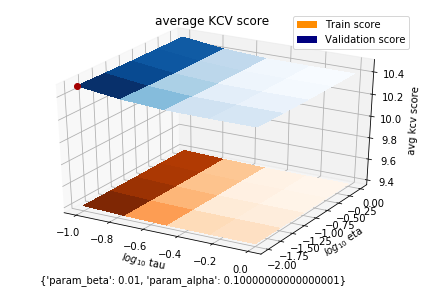

In [196]:
from palladio import plotting; reload(plotting);
plotting.score_surfaces_gridsearch(ltgl, indep_vars=['tau','eta'], logspace=['tau','eta'])

In [166]:
emp_list = list(ltgl.best_estimator_.covariance_)
alpha = ltgl.best_params_['alpha']
beta = ltgl.best_params_['beta']
tau = ltgl.best_params_['tau']

In [153]:
from regain.admm import latent_graph_lasso_; reload(latent_graph_lasso_)
precs = []
lats = []
covss = []
for i in range(len(data_list)):
    lgl = latent_graph_lasso_.LatentGraphLasso(tau=tau, alpha=alpha, assume_centered=False).fit(data_list[i])
    precs.append(lgl.precision_)
    lats.append(lgl.latent_)
    covss.append(lgl.covariance_)

In [160]:
np.allclose(np.array(precs), R_ar + L_ar, atol=1e-2)

True

In [129]:
%%matlab -i emp_list,alpha,beta,tau -o R,S,L,obj,res,iter
%alpha = 0.05;
%beta = 0.25*100;
opts.continuation = 1; opts.num_continuation = 10;
opts.eta = 1; opts.muf = 1e-6;
opts.maxiter = 500; opts.stoptol = 1e-5; 
opts.over_relax_par = 1;

R = []; S = []; L=[];obj=[];res=[];iter=[];
for i=1:size(emp_list,3)
    cov = emp_list(:,:,i);
    n = size(cov,1);opts.mu = n;
    tic; out_B = ADMM_B(cov,alpha,tau,opts); solve_B = toc;
    %%fprintf('ADMM_B: obj: %e, iter: %d, cpu: %3.1f \n',out_B.obj,out_B.iter,solve_B);
    R = [R; out_B.R];
    S = [S; out_B.S];
    L = [L; out_B.L];
    obj = [obj; out_B.obj];
    res = [res; out_B.resid];
    iter = [iter; out_B.iter];
end

In [130]:
R_ar = np.array([R[i*R.shape[1]:(i+1)*R.shape[1]] for i in range(R.shape[0]/R.shape[1])])
L_ar = np.array([L[i*L.shape[1]:(i+1)*L.shape[1]] for i in range(L.shape[0]/L.shape[1])])
K_obs = np.array(K_obs) # K_obs is the matrix of observed samples
K = np.array(K) # K is the real precision matrix
ells = np.array(ells) # the latent matrices

### Error obtained w.r.t. the observed data

In [131]:
print("Error norm time with observed precision: \n Ours: {:.3f}\n Ma: {:.3f}".format(
      error_norm_time(ltgl.best_estimator_.precision_, K_obs),
      error_norm_time(R_ar + L_ar, K_obs)))

Error norm time with observed precision: 
 Ours: 0.055
 Ma: 0.049


### Error obtained w.r.t. the real data

In [169]:
print("Error norm time of ours: \n Precision: {:.3f}\n Latent: {:.3f}\n".format(
      error_norm_time(ltgl.best_estimator_.precision_, K),
      error_norm_time(ltgl.best_estimator_.latent_, ells)))

print("Error norm time of Ma: \n Precision: {:.3f}\n Latent: {:.3f}".format(
      error_norm_time(R_ar + L_ar, K),
      error_norm_time(L_ar, ells)))

Error norm time of ours: 
 Precision: 0.061
 Latent: 0.010

Error norm time of Ma: 
 Precision: 0.049
 Latent: 0.020


### Error in ranks

In [253]:
ltgl.best_estimator_.set_params(beta=1e12,eta=1e12).fit(data_grid)
print [np.linalg.matrix_rank(i) for i in ltgl.best_estimator_.latent_]
print [np.linalg.matrix_rank(i) for i in L_ar]
print [np.linalg.matrix_rank(i) for i in lats]
print np.linalg.matrix_rank(ells)

[10, 10, 10, 10, 10, 10, 10, 10, 9, 10]
[3, 3, 3, 4, 3, 3, 3, 2, 2, 3]
[3, 3, 3, 4, 3, 3, 3, 2, 2, 3]
[2 2 2 2 2 2 2 2 2 2]


In [277]:
ltgl.best_params_['tau']

0.10000000000000001

In [291]:
reload(latent_time_graph_lasso_)
results_time = latent_time_graph_lasso_.latent_time_graph_lasso(
    emp_cov, alpha=0.05, tau=.05, tol=1e-5, rtol=1e-5, rho=1./ emp_cov.shape[0],
    beta=0, eta=0,
    verbose=0, max_iter=500)

print [np.linalg.matrix_rank(i) for i in results_time[3]]

[4, 4, 4, 4, 3, 3, 4, 2, 4]


In [294]:
from regain.admm import latent_time_graph_lasso_v3_
reload(latent_time_graph_lasso_v3_)
results_time = latent_time_graph_lasso_v3_.latent_time_graph_lasso(
    emp_cov, alpha=0.05, tau=.05, tol=1e-5, rtol=1e-5, rho=1./ emp_cov.shape[0],
    beta=0, eta=1e-16,
    verbose=0, max_iter=500)

print [np.linalg.matrix_rank(i) for i in results_time[1]]

[3, 2, 3, 2, 3, 2, 2, 1, 2, 3]


In [135]:
es, Q = np.linalg.eigh(ells_estimated[0])

### Error in structure

In [138]:
for true, predict in zip(K.copy(), ltgl.best_estimator_.precision_.copy()):
    predict[np.abs(predict)<1e-2] = 0
    true[true != 0] = 1
    predict[predict != 0] = 1
    res = true+predict
    #print(res)
    #print(res==1)
    print np.count_nonzero((res==1).astype(int))

46
56
66
64
58
64
52
54
60
64
